## Vesuvius Challenge - Ink Detection Training Notebook

### Setup

In [175]:
# # Pretrained weights
# # ref - https://github.com/kenshohara/3D-ResNets-PyTorch
# !pip install gdown
# !gdown 1Nb4abvIkkp_ydPFA9sNPT1WakoVKA8Fa

# # Utility packages for reading and visualizing volumes
# !pip install zarr imageio-ffmpeg

# # save model checkpoints
# !mkdir ./ckpts

# !kaggle datasets download -d samfc10/vesuvius-zarr-files

In [176]:
import os
import gc
import sys
import zarr
import random
import imageio
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import os,cv2
import gc
import sys
import random
from glob import glob
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import pytorch_lightning as pl
from pytorch_lightning.loggers import WandbLogger
from scipy.ndimage import distance_transform_edt

import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.cuda import amp
from torch.utils.data import Dataset, DataLoader
import segmentation_models_pytorch as smp
import albumentations as A
from albumentations.pytorch import ToTensorV2
from IPython.display import Video

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.cuda import amp
from torch.utils.data import Dataset, DataLoader

# sys.path.append("/kaggle/input/resnet3d")
ROOT_DIR = '/home/fummicc1/codes/competitions/kaggle-ink-detection/'
sys.path.append(ROOT_DIR)
from resnet3d import generate_model

### Config

In [177]:
class CFG:
    DATA_DIR = ROOT_DIR
    # DATA_DIR = "/kaggle/input/vesuvius-zarr-files/"
    LR = 1e-3
    EPOCHS = 30
    BATCH_SIZE = 256
    NUM_WORKERS = 8
    CROP_SIZE = 256
    Z_LIST = (
        # list(range(0, 24, 8)) + list(range(24, 36, 2)) + list(range(36, 64, 10))
        [4, 12] + list(range(24, 36)) + [44, 52]
    )  # Offset of slices in the z direction
    TRAIN_FRAGMENTS = ["1", "3"]
    TEST_FRAGMENT = "2"
    MODEL_DEPTH = 34
    MAX_PIXEL_VALUE = 2 ** 16 - 1
    MAX_PIXEL_VALUE_8bit = 2 ** 8 - 1
    RESIZE_HEIGHT = 4000
    COMP_DATASET_PATH = "/home/fummicc1/codes/competitions/kaggle-ink-detection/"
    
    
    Z_START = Z_LIST[0]    
    Z_DIM = len(Z_LIST)
    mask_padding = 200

### Load data

In [178]:
def resize(img):
    if CFG.RESIZE_HEIGHT is None:
        return img
    current_height, current_width = img.shape[:2]
    aspect_ratio = current_width / current_height
    new_height = CFG.RESIZE_HEIGHT
    new_width = int(new_height * aspect_ratio)
    new_size = (new_width, new_height)
    # (W, H)の順で渡すが結果は(H, W)になっている
    img = cv2.resize(img, new_size)
    return img

In [179]:
def load_mask(split, index):
    img = cv2.imread(f"{CFG.DATA_DIR}/{split}/{index}/mask.png", 0) // CFG.MAX_PIXEL_VALUE_8bit
    img = np.pad(img, 1, constant_values=0)
    dist = distance_transform_edt(img)
    img[dist <= CFG.mask_padding] = 0
    img = img[1:-1, 1:-1]
    img = resize(img)    
    return img

def load_labels(split, index):
    img = cv2.imread(f"{CFG.DATA_DIR}/{split}/{index}/inklabels.png", 0) // CFG.MAX_PIXEL_VALUE_8bit
    img = resize(img)
    return img

In [180]:
def calculate_mean_std(volume):
    # mean_0 = np.mean(volume / 255, axis=0)
    # mean_1 = np.mean(mean_0, axis=0)
    # std_0 = np.std(volume / 255, axis=0)
    # std_1 = np.std(std_0, axis=0)
    mean_1 = np.array([0.45 for i in range(CFG.Z_DIM)])
    std_1 = np.array([0.225 for i in range(CFG.Z_DIM)])
    return mean_1, std_1


In [181]:
def read_image(mode, fragment_id):
    images = []

    # idxs = range(65)
    start = 0
    end = 65
    idxs = range(start, end)

    for i in tqdm(idxs):
        image = cv2.imread(CFG.COMP_DATASET_PATH + f"{mode}/{fragment_id}/surface_volume/{i:02}.tif", -1)
        # image = cv2.imread(CFG.comp_dataset_path + f"{mode}/{fragment_id}/surface_volume/{i:02}.tif", 0)
        
        # print(image.max())
        image = resize(image).astype(np.float32)     
        # print(image.max())

        # pad0 = (CROP_SIZE - image.shape[0] % CROP_SIZE)
        # pad1 = (CROP_SIZE - image.shape[1] % CROP_SIZE)

        # image = np.pad(image, [(0, pad0), (0, pad1)], constant_values=0)
        # print(image.max())
        images.append(image)
    images = np.stack(images, axis=2, dtype=np.float32)
    # print(images.max())
    return images

In [182]:
FRAGMENTS_ZARR = {
    "1" : {},
    "2" : {},
    "3" : {},
}


In [183]:
for key in ["1", "2", "3"]:
    FRAGMENTS_ZARR[key]["surface_volume"] = read_image("train", key)
    FRAGMENTS_ZARR[key]["mask"] = load_mask("train", key)
    FRAGMENTS_ZARR[key]["truth"] = load_labels("train", key)

100%|██████████| 65/65 [00:02<00:00, 25.80it/s]


In [184]:
FRAGMENTS_SHAPE = {k : v["surface_volume"].shape[:-1] for k, v in FRAGMENTS_ZARR.items()}

In [185]:

ALL_MEAN_STD = {}
img = FRAGMENTS_ZARR["1"]["surface_volume"][:, :, CFG.Z_START:CFG.Z_START+CFG.Z_DIM]
mean, std = calculate_mean_std(img)
for key in ["1", "2", "3"]:    
    ALL_MEAN_STD[key] = mean, std
    

In [186]:
mean, std = ALL_MEAN_STD["2"]
mean, std

(array([0.45, 0.45, 0.45, 0.45, 0.45, 0.45, 0.45, 0.45, 0.45, 0.45, 0.45,
        0.45, 0.45, 0.45, 0.45, 0.45]),
 array([0.225, 0.225, 0.225, 0.225, 0.225, 0.225, 0.225, 0.225, 0.225,
        0.225, 0.225, 0.225, 0.225, 0.225, 0.225, 0.225]))

In [187]:
list(FRAGMENTS_ZARR["1"].keys())
# np.unique(np.array(FRAGMENTS_ZARR["1"]["surface_volume"]))

['surface_volume', 'mask', 'truth']

In [188]:
CFG.MAX_PIXEL_VALUE / CFG.MAX_PIXEL_VALUE_8bit

257.0

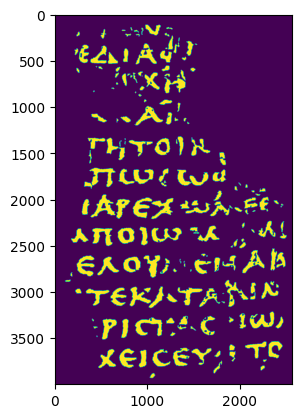

In [189]:
plt.imshow(FRAGMENTS_ZARR["2"]["truth"])

In [190]:
def fetch_fragment_crop(id: str, y1, y2, x1, x2, z1=None, z2=None, key: str = "surface_volume"):
    if key == "surface_volume":
        img = FRAGMENTS_ZARR[id][key][y1:y2, x1:x2, z1:z2]
        return img.astype(np.float32)
    elif key == "truth":
        img = FRAGMENTS_ZARR[id][key][y1:y2, x1:x2]
        return img.astype(np.uint8)
    print("Error", key)

def fetch_fragment(id: str, z1=None, z2=None, key: str = "surface_volume"):
    if key == "surface_volume":
        img = FRAGMENTS_ZARR[id][key][:, :, z1:z2]
        return img.astype(np.float32)
    elif key == "truth":
        img = FRAGMENTS_ZARR[id][key]
        return img.astype(np.uint8)

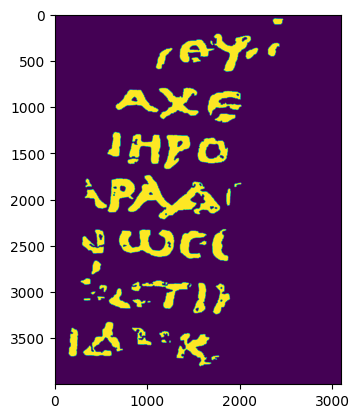

In [191]:
plt.imshow(FRAGMENTS_ZARR["1"]["truth"][:,:])

### Visualise input

In [192]:
fragment_id = FRAGMENTS_ZARR["1"]
x, y = 1000, 1000

# np.unique(FRAGMENTS_ZARR["1"]["surface_volume"][y:y+CROP_SIZE, x:x+CROP_SIZE, :])
fragment_cropped = fetch_fragment_crop("1", y, y+CFG.CROP_SIZE, x, x+CFG.CROP_SIZE, CFG.Z_START, CFG.Z_START+CFG.Z_DIM)
imageio.mimwrite("fragment_crop.mp4", (fragment_cropped.transpose(2, 0, 1) / CFG.MAX_PIXEL_VALUE_8bit), "ffmpeg")
Video("fragment_crop.mp4", height=256, width=256)

Lossy conversion from float32 to uint8. Range [0.0, 257.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0235294122248888, 257.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.062745101749897, 257.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 257.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.003921568859368563, 256.98431396484375]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 257.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 257.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.00392156885936856

(-0.5, 255.5, 255.5, -0.5)

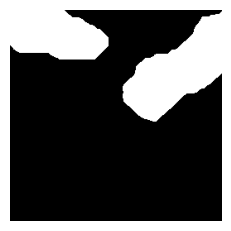

In [193]:
mask_cropped = fragment_id["truth"][y:y+CFG.CROP_SIZE, x:x+CFG.CROP_SIZE]
# ir_cropped = fragment_id["infrared"][y:y+CROP_SIZE, x:x+CROP_SIZE]

plt.figure(figsize=(6, 3))
plt.subplot(1, 2, 1)
plt.imshow(mask_cropped, cmap="gray")
plt.axis("off")

# plt.subplot(1, 2, 2)
# plt.imshow(ir_cropped, cmap="gray")
# plt.axis("off")
# plt.show()

In [194]:
# del fragment_id, fragment_cropped, mask_cropped, ir_cropped
# gc.collect()

### Dataloaders

In [195]:

class VesuviusTrain(Dataset):
    def __init__(self, fragments):
        self.fragments = fragments
        self.xys = []
        
        for fragment_id in fragments:
            H, W = FRAGMENTS_SHAPE[fragment_id]            
            labels = FRAGMENTS_ZARR[fragment_id]["truth"]
            for y in range(0, H-CFG.CROP_SIZE+1, CFG.CROP_SIZE):
                for x in range(0, W-CFG.CROP_SIZE+1, CFG.CROP_SIZE):
                    if np.all(labels[y:y+H, x:x+W] == 0):
                        continue
                    self.xys.append((fragment_id, x, y, W, H))
        
    def __getitem__(self, i):
        fragment_id, x1, y1, W, H = self.xys[i]
        z1, z2 = CFG.Z_START, CFG.Z_START + CFG.Z_DIM
        
        x2 = x1 + CFG.CROP_SIZE
        y2 = y1 + CFG.CROP_SIZE
            
        # print("x1: ", x1, " x2: ", x2, " y1: ", y1, " y2: ", y2)
        
        frag_crop = fetch_fragment_crop(fragment_id, y1, y2, x1, x2, z1, z2)
        label_crop = fetch_fragment_crop(fragment_id, y1, y2, x1, x2, key="truth")[:, :, np.newaxis]
        
        frag_crop /= CFG.MAX_PIXEL_VALUE
                                                        
        performed = A.Compose([
            # A.ToFloat(max_value=1),
            # A.HorizontalFlip(p=0.5), # 水平方向に反転
            # A.VerticalFlip(p=0.5), # 水平方向に反転
            # A.RandomScale(p=0.5),
            # A.RandomRotate90(p=0.5),
            # # A.GridDistortion(num_steps=5, distort_limit=0.3, p=0.3),
            # A.CoarseDropout(
            #     max_holes=1,
            #     max_width=int(CFG.CROP_SIZE * 0.25), 
            #     max_height=int(CFG.CROP_SIZE * 0.25), 
            #     mask_fill_value=0,
            #     p=0.4
            # ),
            # A.ShiftScaleRotate(p=0.7),
            # A.Resize(height=CFG.CROP_SIZE, width=CFG.CROP_SIZE),
            # A.FromFloat(max_value=1),
        ])(image=frag_crop, mask=label_crop)
        frag_crop = performed["image"]        
        label_crop = performed["mask"]
        
        frag_crop = frag_crop.astype(np.float16)
        
        # print("frag_crop", frag_crop[100, 100, :])
        
        mean, std = ALL_MEAN_STD[fragment_id]
        frag_crop = (frag_crop - mean) / std        
        frag_crop = torch.from_numpy(frag_crop.astype(np.float32)).permute(2, 0, 1)        
        
        label_crop = torch.from_numpy(label_crop.astype(np.float32)).permute(2, 0, 1)
        
        # print("frag_crop after norm", frag_crop[:, 100, 100])
        
        assert frag_crop.shape[0] == len(CFG.Z_LIST)
        
        return {
            "images": frag_crop,
            "labels": label_crop
        }

    def __len__(self):
        return len(self.xys)

In [196]:
ALL_MEAN_STD["1"][0].shape, ALL_MEAN_STD["1"][1].shape

((16,), (16,))

In [197]:
class VesuviusVal(Dataset):
    def __init__(self, fragment_id):
        self.fragment_id = fragment_id
        self.xys = []
        
        H, W = FRAGMENTS_SHAPE[fragment_id]
        for y in range(0, H-CFG.CROP_SIZE+1, CFG.CROP_SIZE):
            for x in range(0, W-CFG.CROP_SIZE+1, CFG.CROP_SIZE):
                self.xys.append((x, y))
                
    def __getitem__(self, i):
        x1, y1 = self.xys[i]
        x2, y2 = x1+CFG.CROP_SIZE, y1+CFG.CROP_SIZE
        z1, z2 = CFG.Z_START, CFG.Z_START + CFG.Z_DIM
        
        frag_crop = fetch_fragment_crop(self.fragment_id, y1, y2, x1, x2, z1, z2)
        
        label_crop = fetch_fragment_crop(self.fragment_id, y1, y2, x1, x2, key="truth")[:, :, np.newaxis]
        
        frag_crop = frag_crop / CFG.MAX_PIXEL_VALUE

        mean, std = ALL_MEAN_STD[self.fragment_id]
        
        frag_crop = (frag_crop - mean) / std
        frag_crop = torch.from_numpy(frag_crop.astype(np.float32)).permute(2, 0, 1)        
        
        label_crop = torch.from_numpy(label_crop.astype(np.float32)).permute(2, 0, 1)
        
        # print("frag_crop", frag_crop)
        
        assert frag_crop.shape[0] == len(CFG.Z_LIST)
        
        return {
            "images": frag_crop,
            "labels": label_crop,
            "locations": torch.tensor([x1, y1, x2, y2], dtype=torch.int32)
        }

    def __len__(self):
        return len(self.xys)

In [198]:
def collate_train_fn(batch):
  return {
      'images': torch.stack([x['images'] for x in batch]),
      'labels': torch.stack([x['labels'] for x in batch])
}
  
  
def collate_val_fn(batch):
  return {
      'images': torch.stack([x['images'] for x in batch]),
      'labels': torch.stack([x['labels'] for x in batch]),
      'locations': torch.stack([x['locations'] for x in batch])
}

In [199]:
dataset_train = VesuviusTrain(CFG.TRAIN_FRAGMENTS)
dataloader_train = DataLoader(
    dataset_train, 
    batch_size=CFG.BATCH_SIZE, 
    num_workers=CFG.NUM_WORKERS,
    collate_fn=collate_train_fn,
    shuffle=True
)
n_train = len(dataloader_train)

dataset_valid = VesuviusVal(CFG.TEST_FRAGMENT)
dataloader_valid = DataLoader(
    dataset_valid, 
    batch_size=CFG.BATCH_SIZE, 
    num_workers=CFG.NUM_WORKERS,
    collate_fn=collate_val_fn,
    shuffle=False
)
n_valid = len(dataloader_valid)

### Model
* Encoder is a 3D ResNet model. The architecture has been modified to remove temporal downsampling between blocks.
* A 2D decoder is used for predicting the segmentation map.
* The encoder feature maps are average pooled over the Z dimension before passing it to the decoder.

In [200]:
class Decoder(nn.Module):
    def __init__(self, encoder_dims, upscale):
        super().__init__()
        self.convs = nn.ModuleList([
            nn.Sequential(
                nn.Conv2d(encoder_dims[i]+encoder_dims[i-1], encoder_dims[i-1], 3, 1, 1, bias=False),
                nn.BatchNorm2d(encoder_dims[i-1]),
                nn.ReLU(inplace=True)
            ) for i in range(1, len(encoder_dims))])

        self.logit = nn.Conv2d(encoder_dims[0], 1, 1, 1, 0)
        self.up = nn.Upsample(scale_factor=upscale, mode="bilinear")

    def forward(self, feature_maps):
        for i in range(len(feature_maps)-1, 0, -1):
            f_up = F.interpolate(feature_maps[i], scale_factor=2, mode="bilinear")
            f = torch.cat([feature_maps[i-1], f_up], dim=1)
            f_down = self.convs[i-1](f)
            feature_maps[i-1] = f_down

        x = self.logit(feature_maps[0])
        mask = self.up(x)
        return mask
    
class SegModel(nn.Module):
    def __init__(self,model_depth=CFG.MODEL_DEPTH):
        super().__init__()
        self.encoder = generate_model(model_depth=CFG.MODEL_DEPTH, n_input_channels=1)
        self.decoder = Decoder(encoder_dims=[64, 128, 256, 512], upscale=4)
        
    def forward(self, x):
        if x.ndim==4:
            x=x[:,None] # チャネルを追加
        
        feat_maps = self.encoder(x)
        feat_maps_pooled = [torch.mean(f, dim=2) for f in feat_maps]
        pred_mask = self.decoder(feat_maps_pooled)
        return pred_mask
    
    def load_pretrained_weights(self, state_dict):
        # Convert 3 channel weights to single channel
        # ref - https://timm.fast.ai/models#Case-1:-When-the-number-of-input-channels-is-1
        conv1_weight = state_dict['conv1.weight']
        state_dict['conv1.weight'] = conv1_weight.sum(dim=1, keepdim=True)
        print(self.encoder.load_state_dict(state_dict, strict=False))
        
   
class CustomModel(nn.Module):
    def __init__(self):
        super().__init__()

        self.encoder=SegModel()
        weight_path = f"r3d{CFG.MODEL_DEPTH}_K_200ep.pth"
        if os.path.exists(weight_path):            
            self.encoder.load_pretrained_weights(torch.load(weight_path)["state_dict"])

    def forward(self, images:torch.Tensor):
        #image.shape=(b,C,H,W)
        if images.ndim==4:
            images=images[:,None]
        # images=normalization(images)
        output = self.encoder(images)
        return output

In [201]:
model = CustomModel()
model = nn.DataParallel(model, device_ids=[0, 1, 2, 3])
model = model.cuda()

_IncompatibleKeys(missing_keys=[], unexpected_keys=['fc.weight', 'fc.bias'])


### Competition metric (F0.5 Score)

In [202]:
# ref - https://www.kaggle.com/competitions/vesuvius-challenge-ink-detection/discussion/397288
def fbeta_score(preds, targets, threshold, beta=0.5, smooth=1e-5):
    preds_t = torch.where(preds > threshold, 1.0, 0.0).float()
    y_true_count = targets.sum()
    
    ctp = preds_t[targets==1].sum()
    cfp = preds_t[targets==0].sum()
    beta_squared = beta * beta

    c_precision = ctp / (ctp + cfp + smooth)
    c_recall = ctp / (y_true_count + smooth)
    dice = (1 + beta_squared) * (c_precision * c_recall) / (beta_squared * c_precision + c_recall + smooth)

    return dice

### Training

In [203]:
scaler = amp.GradScaler()
TverskyLoss = smp.losses.TverskyLoss(mode='binary', alpha=0.5, beta=0.7, smooth=1e-6)
BCELoss = smp.losses.SoftBCEWithLogitsLoss()
DiceLoss = smp.losses.DiceLoss(mode="binary", smooth=1e-6)
optimizer = torch.optim.AdamW(model.parameters(), lr=CFG.LR)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", factor=0.05, patience=4)

def criterion(pred,target):
    return 0.7 * TverskyLoss(pred, target) + 0.3 * BCELoss(pred, target)

In [204]:
gt_mask = torch.from_numpy(np.asarray(FRAGMENTS_ZARR[CFG.TEST_FRAGMENT]["truth"])).float().cuda()
gt_shape = FRAGMENTS_SHAPE[CFG.TEST_FRAGMENT]

In [205]:
for epoch in range(1, CFG.EPOCHS+1):
    model.train()
    cur_lr = optimizer.param_groups[0]['lr']
    pbar_train = enumerate(dataloader_train)
    pbar_train = tqdm(pbar_train, total=n_train, bar_format="{l_bar}{bar:10}{r_bar}{bar:-10b}")
    mloss_train, mloss_val, val_metric = 0.0, 0.0, 0.0

    for i, batches in pbar_train:
        fragments = batches["images"]
        labels = batches["labels"]
        fragments, labels = fragments.cuda(), labels.cuda()
        optimizer.zero_grad()
        with amp.autocast():
            pred_masks = model(fragments)
            loss = criterion(pred_masks, labels)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            mloss_train += loss.detach().item()

        gpu_mem = f"Mem : {torch.cuda.memory_reserved() / 1E9:.3g}GB"
        pbar_train.set_description(("%10s  " * 3 + "%10s") % (f"Epoch {epoch}/{CFG.EPOCHS}", gpu_mem, cur_lr,
                                                              f"Loss: {mloss_train / (i + 1):.4f}"))    
    model.eval()
    pbar_val = enumerate(dataloader_valid)
    pbar_val = tqdm(pbar_val, total=n_valid, bar_format="{l_bar}{bar:10}{r_bar}{bar:-10b}")
    final_pred_mask = torch.zeros(gt_shape, dtype=torch.float32, device='cuda')
    
    for i, batches in pbar_val:
        fragments = batches["images"]
        labels = batches["labels"]
        xys = batches["locations"]
        fragments, labels = fragments.cuda(), labels.cuda()
        with torch.no_grad():
            pred_masks = model(fragments)
            mloss_val += criterion(pred_masks, labels).item()
            pred_masks = torch.sigmoid(pred_masks)
        
        for j, xy in enumerate(xys):
            final_pred_mask[xy[1]:xy[3], xy[0]:xy[2]] = pred_masks[j, 0]

        pbar_val.set_description(("%10s") % (f"Val Loss: {mloss_val / (i+1):.4f}"))
    
    model.train()
    scheduler.step(metrics=mloss_val)
    
    for threshold in np.arange(0.2, 0.65, 0.05):
        fbeta = fbeta_score(final_pred_mask, gt_mask, threshold)
        print(f"Threshold : {threshold:.2f}\tFBeta : {fbeta:.6f}")
    
    if epoch % 10 == 0:
        torch.save(model.module.state_dict(), f"./ckpts/resnet{CFG.MODEL_DEPTH}_val_{CFG.TEST_FRAGMENT}_3d_seg_epoch_{epoch}.pt")

    if epoch == 30:
        break

Epoch 1/30  Mem : 44.6GB       0.001  Loss: 0.7970: 100%|██████████| 2/2 [00:04<00:00,  2.45s/it]
Val Loss: 8.0905: 100%|██████████| 1/1 [00:02<00:00,  2.06s/it]

Threshold : 0.20	FBeta : 0.150653
Threshold : 0.25	FBeta : 0.150653
Threshold : 0.30	FBeta : 0.150653
Threshold : 0.35	FBeta : 0.150653
Threshold : 0.40	FBeta : 0.150653
Threshold : 0.45	FBeta : 0.150653
Threshold : 0.50	FBeta : 0.150653
Threshold : 0.55	FBeta : 0.150653
Threshold : 0.60	FBeta : 0.150653



Epoch 2/30  Mem : 49.9GB       0.001  Loss: 0.7899: 100%|██████████| 2/2 [00:04<00:00,  2.43s/it]
Val Loss: 5.1483: 100%|██████████| 1/1 [00:01<00:00,  1.97s/it]

Threshold : 0.20	FBeta : 0.148723
Threshold : 0.25	FBeta : 0.148888
Threshold : 0.30	FBeta : 0.149025
Threshold : 0.35	FBeta : 0.149153
Threshold : 0.40	FBeta : 0.149269
Threshold : 0.45	FBeta : 0.149385
Threshold : 0.50	FBeta : 0.149489
Threshold : 0.55	FBeta : 0.149609
Threshold : 0.60	FBeta : 0.149737



Epoch 3/30  Mem : 49.9GB       0.001  Loss: 0.7427: 100%|██████████| 2/2 [00:04<00:00,  2.42s/it]
Val Loss: 7126.8682: 100%|██████████| 1/1 [00:01<00:00,  1.98s/it]

Threshold : 0.20	FBeta : 0.150653
Threshold : 0.25	FBeta : 0.150653
Threshold : 0.30	FBeta : 0.150653
Threshold : 0.35	FBeta : 0.150653
Threshold : 0.40	FBeta : 0.150653
Threshold : 0.45	FBeta : 0.150653
Threshold : 0.50	FBeta : 0.150653
Threshold : 0.55	FBeta : 0.150653
Threshold : 0.60	FBeta : 0.150653



Epoch 4/30  Mem : 49.9GB       0.001  Loss: 0.7493: 100%|██████████| 2/2 [00:04<00:00,  2.40s/it]
Val Loss: 2260.6494: 100%|██████████| 1/1 [00:01<00:00,  1.98s/it]

Threshold : 0.20	FBeta : 0.150653
Threshold : 0.25	FBeta : 0.150653
Threshold : 0.30	FBeta : 0.150653
Threshold : 0.35	FBeta : 0.150653
Threshold : 0.40	FBeta : 0.150653
Threshold : 0.45	FBeta : 0.150653
Threshold : 0.50	FBeta : 0.150653
Threshold : 0.55	FBeta : 0.150653
Threshold : 0.60	FBeta : 0.150653



Epoch 5/30  Mem : 49.9GB       0.001  Loss: 0.7076: 100%|██████████| 2/2 [00:04<00:00,  2.42s/it]
Val Loss: 3566.8723: 100%|██████████| 1/1 [00:01<00:00,  1.95s/it]

Threshold : 0.20	FBeta : 0.150653
Threshold : 0.25	FBeta : 0.150653
Threshold : 0.30	FBeta : 0.150653
Threshold : 0.35	FBeta : 0.150653
Threshold : 0.40	FBeta : 0.150653
Threshold : 0.45	FBeta : 0.150653
Threshold : 0.50	FBeta : 0.150653
Threshold : 0.55	FBeta : 0.150653
Threshold : 0.60	FBeta : 0.150653



Epoch 6/30  Mem : 49.9GB       0.001  Loss: 0.7217: 100%|██████████| 2/2 [00:05<00:00,  2.50s/it]
Val Loss: 291.6099: 100%|██████████| 1/1 [00:02<00:00,  2.00s/it]

Threshold : 0.20	FBeta : 0.150653
Threshold : 0.25	FBeta : 0.150653
Threshold : 0.30	FBeta : 0.150653
Threshold : 0.35	FBeta : 0.150653
Threshold : 0.40	FBeta : 0.150653
Threshold : 0.45	FBeta : 0.150653
Threshold : 0.50	FBeta : 0.150653
Threshold : 0.55	FBeta : 0.150653
Threshold : 0.60	FBeta : 0.150653



Epoch 7/30  Mem : 49.9GB       0.001  Loss: 0.7170: 100%|██████████| 2/2 [00:04<00:00,  2.43s/it]
Val Loss: 101.6124: 100%|██████████| 1/1 [00:02<00:00,  2.03s/it]

Threshold : 0.20	FBeta : 0.150653
Threshold : 0.25	FBeta : 0.150653
Threshold : 0.30	FBeta : 0.150653
Threshold : 0.35	FBeta : 0.150653
Threshold : 0.40	FBeta : 0.150653
Threshold : 0.45	FBeta : 0.150653
Threshold : 0.50	FBeta : 0.150653
Threshold : 0.55	FBeta : 0.150653
Threshold : 0.60	FBeta : 0.150653



Epoch 8/30  Mem : 49.9GB       5e-05  Loss: 0.6995: 100%|██████████| 2/2 [00:04<00:00,  2.43s/it]
Val Loss: 11.5150: 100%|██████████| 1/1 [00:02<00:00,  2.04s/it]

Threshold : 0.20	FBeta : 0.150653
Threshold : 0.25	FBeta : 0.150653
Threshold : 0.30	FBeta : 0.150653
Threshold : 0.35	FBeta : 0.150653
Threshold : 0.40	FBeta : 0.150654
Threshold : 0.45	FBeta : 0.150651
Threshold : 0.50	FBeta : 0.150642
Threshold : 0.55	FBeta : 0.150587
Threshold : 0.60	FBeta : 0.150492



Epoch 9/30  Mem : 49.9GB       5e-05  Loss: 0.6836: 100%|██████████| 2/2 [00:04<00:00,  2.43s/it]
Val Loss: 3.0267: 100%|██████████| 1/1 [00:01<00:00,  1.95s/it]

Threshold : 0.20	FBeta : 0.150688
Threshold : 0.25	FBeta : 0.150764
Threshold : 0.30	FBeta : 0.151084
Threshold : 0.35	FBeta : 0.151047
Threshold : 0.40	FBeta : 0.150863
Threshold : 0.45	FBeta : 0.150912
Threshold : 0.50	FBeta : 0.151570
Threshold : 0.55	FBeta : 0.153222
Threshold : 0.60	FBeta : 0.155059



Epoch 10/30  Mem : 49.9GB       5e-05  Loss: 0.6983: 100%|██████████| 2/2 [00:04<00:00,  2.42s/it]
Val Loss: 1.4334: 100%|██████████| 1/1 [00:01<00:00,  1.96s/it]


Threshold : 0.20	FBeta : 0.200072
Threshold : 0.25	FBeta : 0.207307
Threshold : 0.30	FBeta : 0.208784
Threshold : 0.35	FBeta : 0.210251
Threshold : 0.40	FBeta : 0.210748
Threshold : 0.45	FBeta : 0.212516
Threshold : 0.50	FBeta : 0.213354
Threshold : 0.55	FBeta : 0.214986
Threshold : 0.60	FBeta : 0.216934


Epoch 11/30  Mem : 49.9GB       5e-05  Loss: 0.6798: 100%|██████████| 2/2 [00:04<00:00,  2.44s/it]
Val Loss: 0.9363: 100%|██████████| 1/1 [00:02<00:00,  2.04s/it]

Threshold : 0.20	FBeta : 0.211687
Threshold : 0.25	FBeta : 0.214121
Threshold : 0.30	FBeta : 0.215911
Threshold : 0.35	FBeta : 0.215946
Threshold : 0.40	FBeta : 0.215404
Threshold : 0.45	FBeta : 0.214021
Threshold : 0.50	FBeta : 0.213275
Threshold : 0.55	FBeta : 0.208002
Threshold : 0.60	FBeta : 0.202521



Epoch 12/30  Mem : 49.9GB       5e-05  Loss: 0.7525: 100%|██████████| 2/2 [00:04<00:00,  2.43s/it]
Val Loss: 0.8823: 100%|██████████| 1/1 [00:01<00:00,  1.99s/it]


Threshold : 0.20	FBeta : 0.212334
Threshold : 0.25	FBeta : 0.214810
Threshold : 0.30	FBeta : 0.216655
Threshold : 0.35	FBeta : 0.216617
Threshold : 0.40	FBeta : 0.214692
Threshold : 0.45	FBeta : 0.213065
Threshold : 0.50	FBeta : 0.212640
Threshold : 0.55	FBeta : 0.207022
Threshold : 0.60	FBeta : 0.199217


Epoch 13/30  Mem : 49.9GB       5e-05  Loss: 0.7135: 100%|██████████| 2/2 [00:04<00:00,  2.44s/it]
Val Loss: 0.7871: 100%|██████████| 1/1 [00:01<00:00,  2.00s/it]

Threshold : 0.20	FBeta : 0.215723
Threshold : 0.25	FBeta : 0.217807
Threshold : 0.30	FBeta : 0.218702
Threshold : 0.35	FBeta : 0.216995
Threshold : 0.40	FBeta : 0.213326
Threshold : 0.45	FBeta : 0.210439
Threshold : 0.50	FBeta : 0.204916
Threshold : 0.55	FBeta : 0.191106
Threshold : 0.60	FBeta : 0.182527



Epoch 14/30  Mem : 49.9GB       5e-05  Loss: 0.6932: 100%|██████████| 2/2 [00:04<00:00,  2.43s/it]
Val Loss: 0.7396: 100%|██████████| 1/1 [00:02<00:00,  2.04s/it]

Threshold : 0.20	FBeta : 0.217664
Threshold : 0.25	FBeta : 0.219441
Threshold : 0.30	FBeta : 0.219410
Threshold : 0.35	FBeta : 0.216784
Threshold : 0.40	FBeta : 0.212835
Threshold : 0.45	FBeta : 0.207781
Threshold : 0.50	FBeta : 0.199899
Threshold : 0.55	FBeta : 0.177802
Threshold : 0.60	FBeta : 0.165896



Epoch 15/30  Mem : 49.9GB       5e-05  Loss: 0.6821: 100%|██████████| 2/2 [00:04<00:00,  2.42s/it]
Val Loss: 0.7162: 100%|██████████| 1/1 [00:01<00:00,  2.00s/it]


Threshold : 0.20	FBeta : 0.219221
Threshold : 0.25	FBeta : 0.220476
Threshold : 0.30	FBeta : 0.219732
Threshold : 0.35	FBeta : 0.216605
Threshold : 0.40	FBeta : 0.212591
Threshold : 0.45	FBeta : 0.206956
Threshold : 0.50	FBeta : 0.196663
Threshold : 0.55	FBeta : 0.167244
Threshold : 0.60	FBeta : 0.154141


Epoch 16/30  Mem : 49.9GB       5e-05  Loss: 0.6747: 100%|██████████| 2/2 [00:04<00:00,  2.43s/it]
Val Loss: 0.6963: 100%|██████████| 1/1 [00:02<00:00,  2.03s/it]

Threshold : 0.20	FBeta : 0.219976
Threshold : 0.25	FBeta : 0.220952
Threshold : 0.30	FBeta : 0.219890
Threshold : 0.35	FBeta : 0.216529
Threshold : 0.40	FBeta : 0.211982
Threshold : 0.45	FBeta : 0.206429
Threshold : 0.50	FBeta : 0.193055
Threshold : 0.55	FBeta : 0.152325
Threshold : 0.60	FBeta : 0.129332



Epoch 17/30  Mem : 49.9GB       5e-05  Loss: 0.6594: 100%|██████████| 2/2 [00:04<00:00,  2.42s/it]
Val Loss: 0.6897: 100%|██████████| 1/1 [00:01<00:00,  1.95s/it]

Threshold : 0.20	FBeta : 0.220066
Threshold : 0.25	FBeta : 0.221146
Threshold : 0.30	FBeta : 0.220367
Threshold : 0.35	FBeta : 0.217234
Threshold : 0.40	FBeta : 0.212735
Threshold : 0.45	FBeta : 0.207423
Threshold : 0.50	FBeta : 0.193832
Threshold : 0.55	FBeta : 0.142440
Threshold : 0.60	FBeta : 0.108281



Epoch 18/30  Mem : 49.9GB       5e-05  Loss: 0.6837: 100%|██████████| 2/2 [00:04<00:00,  2.44s/it]
Val Loss: 0.6838: 100%|██████████| 1/1 [00:02<00:00,  2.00s/it]

Threshold : 0.20	FBeta : 0.220243
Threshold : 0.25	FBeta : 0.221183
Threshold : 0.30	FBeta : 0.220295
Threshold : 0.35	FBeta : 0.217052
Threshold : 0.40	FBeta : 0.212996
Threshold : 0.45	FBeta : 0.206599
Threshold : 0.50	FBeta : 0.187953
Threshold : 0.55	FBeta : 0.125300
Threshold : 0.60	FBeta : 0.087073



Epoch 19/30  Mem : 49.9GB       5e-05  Loss: 0.7030: 100%|██████████| 2/2 [00:04<00:00,  2.42s/it]
Val Loss: 0.6813: 100%|██████████| 1/1 [00:02<00:00,  2.02s/it]


Threshold : 0.20	FBeta : 0.221184
Threshold : 0.25	FBeta : 0.221606
Threshold : 0.30	FBeta : 0.220078
Threshold : 0.35	FBeta : 0.216664
Threshold : 0.40	FBeta : 0.213130
Threshold : 0.45	FBeta : 0.206725
Threshold : 0.50	FBeta : 0.187937
Threshold : 0.55	FBeta : 0.125784
Threshold : 0.60	FBeta : 0.087246


Epoch 20/30  Mem : 49.9GB       5e-05  Loss: 0.6751: 100%|██████████| 2/2 [00:04<00:00,  2.43s/it]
Val Loss: 0.6789: 100%|██████████| 1/1 [00:01<00:00,  1.98s/it]


Threshold : 0.20	FBeta : 0.221384
Threshold : 0.25	FBeta : 0.221523
Threshold : 0.30	FBeta : 0.219564
Threshold : 0.35	FBeta : 0.215563
Threshold : 0.40	FBeta : 0.212016
Threshold : 0.45	FBeta : 0.205290
Threshold : 0.50	FBeta : 0.184042
Threshold : 0.55	FBeta : 0.122556
Threshold : 0.60	FBeta : 0.075733


Epoch 21/30  Mem : 49.9GB       5e-05  Loss: 0.6776: 100%|██████████| 2/2 [00:04<00:00,  2.44s/it]
Val Loss: 0.6777: 100%|██████████| 1/1 [00:01<00:00,  1.97s/it]

Threshold : 0.20	FBeta : 0.221615
Threshold : 0.25	FBeta : 0.221315
Threshold : 0.30	FBeta : 0.218877
Threshold : 0.35	FBeta : 0.214838
Threshold : 0.40	FBeta : 0.211456
Threshold : 0.45	FBeta : 0.205043
Threshold : 0.50	FBeta : 0.179994
Threshold : 0.55	FBeta : 0.109423
Threshold : 0.60	FBeta : 0.041952



Epoch 22/30  Mem : 49.9GB       5e-05  Loss: 0.6705: 100%|██████████| 2/2 [00:04<00:00,  2.45s/it]
Val Loss: 0.6783: 100%|██████████| 1/1 [00:02<00:00,  2.09s/it]

Threshold : 0.20	FBeta : 0.221406
Threshold : 0.25	FBeta : 0.221177
Threshold : 0.30	FBeta : 0.218658
Threshold : 0.35	FBeta : 0.214527
Threshold : 0.40	FBeta : 0.211584
Threshold : 0.45	FBeta : 0.204741
Threshold : 0.50	FBeta : 0.174587
Threshold : 0.55	FBeta : 0.087592
Threshold : 0.60	FBeta : 0.014064



Epoch 23/30  Mem : 49.9GB       5e-05  Loss: 0.7120: 100%|██████████| 2/2 [00:04<00:00,  2.43s/it]
Val Loss: 0.6786: 100%|██████████| 1/1 [00:02<00:00,  2.02s/it]

Threshold : 0.20	FBeta : 0.221131
Threshold : 0.25	FBeta : 0.221171
Threshold : 0.30	FBeta : 0.218730
Threshold : 0.35	FBeta : 0.214484
Threshold : 0.40	FBeta : 0.211602
Threshold : 0.45	FBeta : 0.203852
Threshold : 0.50	FBeta : 0.170919
Threshold : 0.55	FBeta : 0.078094
Threshold : 0.60	FBeta : 0.007270



Epoch 24/30  Mem : 49.9GB       5e-05  Loss: 0.6760: 100%|██████████| 2/2 [00:04<00:00,  2.45s/it]
Val Loss: 0.6782: 100%|██████████| 1/1 [00:02<00:00,  2.00s/it]

Threshold : 0.20	FBeta : 0.221571
Threshold : 0.25	FBeta : 0.220286
Threshold : 0.30	FBeta : 0.216626
Threshold : 0.35	FBeta : 0.213533
Threshold : 0.40	FBeta : 0.209764
Threshold : 0.45	FBeta : 0.198218
Threshold : 0.50	FBeta : 0.151217
Threshold : 0.55	FBeta : 0.055080
Threshold : 0.60	FBeta : 0.004229



Epoch 25/30  Mem : 49.9GB       5e-05  Loss: 0.6739: 100%|██████████| 2/2 [00:04<00:00,  2.43s/it]
Val Loss: 0.6789: 100%|██████████| 1/1 [00:02<00:00,  2.05s/it]

Threshold : 0.20	FBeta : 0.221234
Threshold : 0.25	FBeta : 0.220575
Threshold : 0.30	FBeta : 0.217214
Threshold : 0.35	FBeta : 0.213660
Threshold : 0.40	FBeta : 0.209705
Threshold : 0.45	FBeta : 0.198513
Threshold : 0.50	FBeta : 0.150845
Threshold : 0.55	FBeta : 0.055027
Threshold : 0.60	FBeta : 0.004322



Epoch 26/30  Mem : 49.9GB       5e-05  Loss: 0.6692: 100%|██████████| 2/2 [00:04<00:00,  2.43s/it]
Val Loss: 0.6787: 100%|██████████| 1/1 [00:01<00:00,  1.97s/it]

Threshold : 0.20	FBeta : 0.221301
Threshold : 0.25	FBeta : 0.220570
Threshold : 0.30	FBeta : 0.217193
Threshold : 0.35	FBeta : 0.213863
Threshold : 0.40	FBeta : 0.209959
Threshold : 0.45	FBeta : 0.198846
Threshold : 0.50	FBeta : 0.152205
Threshold : 0.55	FBeta : 0.058758
Threshold : 0.60	FBeta : 0.004625



Epoch 27/30  Mem : 49.9GB     2.5e-06  Loss: 0.6620: 100%|██████████| 2/2 [00:04<00:00,  2.43s/it]
Val Loss: 0.6777: 100%|██████████| 1/1 [00:01<00:00,  1.98s/it]

Threshold : 0.20	FBeta : 0.221651
Threshold : 0.25	FBeta : 0.220394
Threshold : 0.30	FBeta : 0.216786
Threshold : 0.35	FBeta : 0.213790
Threshold : 0.40	FBeta : 0.209742
Threshold : 0.45	FBeta : 0.198060
Threshold : 0.50	FBeta : 0.149600
Threshold : 0.55	FBeta : 0.054153
Threshold : 0.60	FBeta : 0.004813



Epoch 28/30  Mem : 49.9GB     2.5e-06  Loss: 0.7139: 100%|██████████| 2/2 [00:04<00:00,  2.43s/it]
Val Loss: 0.6782: 100%|██████████| 1/1 [00:02<00:00,  2.02s/it]

Threshold : 0.20	FBeta : 0.221421
Threshold : 0.25	FBeta : 0.221047
Threshold : 0.30	FBeta : 0.218123
Threshold : 0.35	FBeta : 0.214536
Threshold : 0.40	FBeta : 0.211128
Threshold : 0.45	FBeta : 0.202200
Threshold : 0.50	FBeta : 0.161200
Threshold : 0.55	FBeta : 0.063875
Threshold : 0.60	FBeta : 0.005393



Epoch 29/30  Mem : 49.9GB     2.5e-06  Loss: 0.7004: 100%|██████████| 2/2 [00:04<00:00,  2.44s/it]
Val Loss: 0.6790: 100%|██████████| 1/1 [00:02<00:00,  2.07s/it]

Threshold : 0.20	FBeta : 0.221152
Threshold : 0.25	FBeta : 0.220929
Threshold : 0.30	FBeta : 0.218010
Threshold : 0.35	FBeta : 0.214135
Threshold : 0.40	FBeta : 0.210787
Threshold : 0.45	FBeta : 0.201378
Threshold : 0.50	FBeta : 0.160100
Threshold : 0.55	FBeta : 0.063141
Threshold : 0.60	FBeta : 0.005231



Epoch 30/30  Mem : 49.9GB     2.5e-06  Loss: 0.6760: 100%|██████████| 2/2 [00:04<00:00,  2.44s/it]
Val Loss: 0.6786: 100%|██████████| 1/1 [00:01<00:00,  1.98s/it]


Threshold : 0.20	FBeta : 0.221414
Threshold : 0.25	FBeta : 0.220432
Threshold : 0.30	FBeta : 0.216931
Threshold : 0.35	FBeta : 0.213672
Threshold : 0.40	FBeta : 0.209780
Threshold : 0.45	FBeta : 0.198034
Threshold : 0.50	FBeta : 0.150226
Threshold : 0.55	FBeta : 0.054094
Threshold : 0.60	FBeta : 0.003964
